In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [274]:
df = pd.read_csv('../../Data/PublicationsWAddresses.csv')

In [275]:
valid_departments = ['Business IT', 'Computer Science', 'Digital Design']

In [276]:
years = list(range(2000, 2024)) #Years exclusive 2024

In [277]:
def plot_collaborations(df, years, top_n=10, international_cummulated=False, department=None, smoothing=None, window=3):
    """
    Plot the number of collaborations per year.
    
    1. **Top-N Countries**: 
       - Plots the top `top_n` countries (based on total collaborations) across the 
         specified years. Each country gets its own subplot. 
       - Offers optional smoothing of the time series data. Supported smoothing methods: 
         'trailing', 'centered', or 'gaussian'.
    
    2. **Denmark vs. International** (if `international_cummulated=True`):
       - Aggregates all countries except Denmark under 'International' and plots 
         Denmark (labeled 'National') vs. the cumulative count of all other countries.
       - Also supports optional smoothing of the time series data.
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing publication data. Must include at least 'Year' and 'Country' 
        columns. Additionally, filtering by department is possibble: 'Business IT', 'Computer Science', 
        and 'Digital Design' with values indicating (1) or not (0).
    
    years : list or range
        A list or range of years (as integers) to include in the plots.
    
    top_n : int, optional
        The number of top countries (by total collaborations) to include in the 
        Top-N Countries mode. Defaults to 10.
    
    international_cummulated : bool, optional
        If set to True, instead of plotting the Top-N Countries, the function will 
        group all countries except Denmark into a single 'International' category 
        and plot them against Denmark ('National'). Defaults to False.
    
    department : str, optional
        If provided, filters the DataFrame to rows matching one of the valid department 
        columns: 'Business IT', 'Computer Science', or 'Digital Design'. Only rows 
        where the chosen department column is 1 will be included. Defaults to None 
        (no department-based filtering).
    
    smoothing : {None, 'trailing', 'centered', 'gaussian'}, optional
        Determines if and how to smooth the time series data:
        - None:     No smoothing (plots raw counts).
        - 'trailing':   Uses a trailing window average.
        - 'centered':   Uses a centered window average.
        - 'gaussian':   Uses a Gaussian window average.
        Defaults to None.
    
    window : int, optional
        The rolling window size for smoothing operations. Defaults to 3.
    
    Returns
    -------
    None
        Displays the resulting plots directly.
    """


    # Ensure 'Year' is integer for proper sorting
    df['Year'] = df['Year'].astype(int)
    
    # Filter the dataframe for the specified department, if provided
    if department:
        valid_departments = ['Business IT', 'Computer Science', 'Digital Design']
        if department in valid_departments:
            department_col_map = {
                'Business IT': 'Business IT',
                'Computer Science': 'Computer Science',
                'Digital Design': 'Digital Design'
            }
            # Select only rows where the department column value is 1
            df = df[df[department_col_map[department]] == 1]

    # Filter the dataframe for the specified years
    df_filtered = df[df['Year'].isin(years)]

    # Group by Year and Country, then count the number of collaborations
    yearly_country_counts = df_filtered.groupby(['Year', 'Country']).size().reset_index(name='Collaborations')

    # Pivot the table to have years as rows and countries as columns
    pivot_df = yearly_country_counts.pivot(index='Year', columns='Country', values='Collaborations').fillna(0)

    # Create a title prefix based on department
    title_prefix = f"{department}" if department else ""
    
    # Adjust x-axis ticks to always start at 2000 with 5-year increments
    start_year = 2000
    end_year = pivot_df.index.max()
    selected_years = list(range(start_year, end_year + 1, 5))
    
    
    if international_cummulated:
        # Aggregate all countries except Denmark as 'International' and keep 'National' (Denmark)
        pivot_df['International'] = pivot_df.drop(columns='Denmark', errors='ignore').sum(axis=1)
        pivot_df['National'] = pivot_df['Denmark'] if 'Denmark' in pivot_df.columns else 0

        # Prepare the data for plotting
        plot_df = pivot_df[['National', 'International']]
        #print(plot_df)
        plot_df_alpha = plot_df.copy()
        
        if smoothing == 'trailing':
            plot_df = plot_df.rolling(window=window, min_periods=1).mean()
        elif smoothing == 'centered':
            plot_df = plot_df.rolling(window=window, min_periods=1, center=True).mean()
        elif smoothing == 'gaussian':
            plot_df = plot_df.rolling(window=window, min_periods=1, win_type='gaussian').mean(std=window / 2)

        # Plotting
        plt.figure(figsize=(7, 5))
        for col in plot_df.columns:
            plt.plot(plot_df.index, plot_df[col], marker='o', label=col + " smoothed")
        
        if smoothing:
            for col in plot_df.columns:
                plt.plot(plot_df_alpha.index, plot_df_alpha[col], label=col + " raw", alpha=0.5)

        plt.title(f'{title_prefix} National (Denmark) vs. International', fontsize=12)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Number of Collaborations', fontsize=12)
        plt.legend(title='Category', fontsize=12, title_fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(selected_years)
        plt.tight_layout()
        plt.show()
            
    else:
        # Top countries
        # Assuming pivot_df, top_n, smoothing, window, and other variables are already defined
    
        # Select the top N countries based on total Collaborations
        top_countries = pivot_df.sum().nlargest(top_n).index
    
        # Filter the pivot dataframe to include only the top N countries
        top_df = pivot_df[top_countries]
        top_df_alpha = top_df.copy()
    
        if smoothing == 'trailing':
            top_df = top_df.rolling(window=window, min_periods=1).mean()
        elif smoothing == 'centered':
            top_df = top_df.rolling(window=window, min_periods=1, center=True).mean()
        elif smoothing == 'gaussian':
            top_df = top_df.rolling(window=window, min_periods=1, win_type='gaussian').mean(std=window / 2)
    
        # Plotting
        num_countries = len(top_countries)
        fig, axes = plt.subplots(4, 3, figsize=(14, 14), sharex=True, sharey=True)
    
        # Generate a color palette suitable for colorblind individuals
        color_palette = sns.color_palette("colorblind", num_countries)
    
        axes = axes.flatten()
        for i, (country, color) in enumerate(zip(top_countries, color_palette)):
            ax = axes[i]
            ax.plot(top_df.index, top_df[country], marker='o', label=f"{country} smoothed", color=color)
    
            if smoothing:
                ax.plot(top_df_alpha.index, top_df_alpha[country], label=f"{country} raw", alpha=0.5, color=color)
    
            ax.set_title(f"{country}", fontsize=12)
            ax.legend(fontsize=10, loc='upper left')
            ax.grid(True, linestyle='--', alpha=0.5)
    
        # Hide any unused subplots
        for j in range(len(top_countries), len(axes)):
            axes[j].axis('off')
        
        plt.xticks(selected_years)
    
        # Add common x-axis and y-axis labels
        fig.text(0.5, 0.04, 'Year', ha='center', fontsize=12)
        fig.text(0.04, 0.5, 'Number of Collaborations', va='center', rotation='vertical', fontsize=12)
    
        # Adjust layout to avoid overlap
        fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
        plt.show()


In [278]:
international_cummulated=True

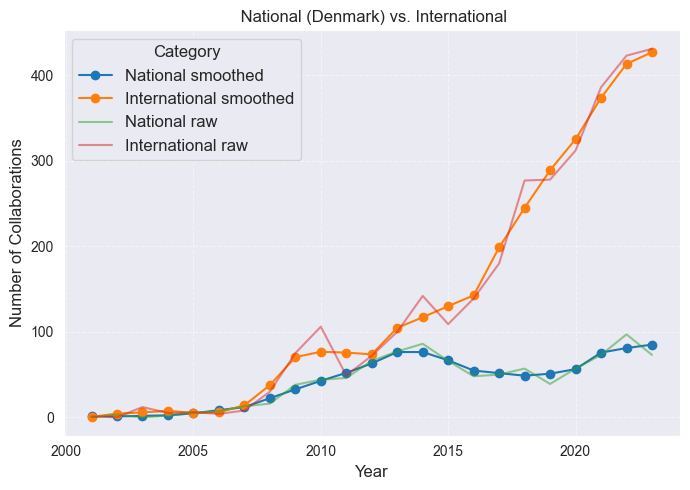

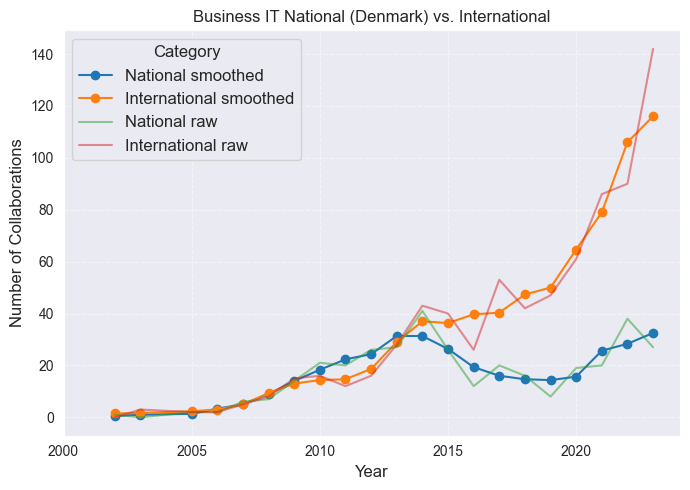

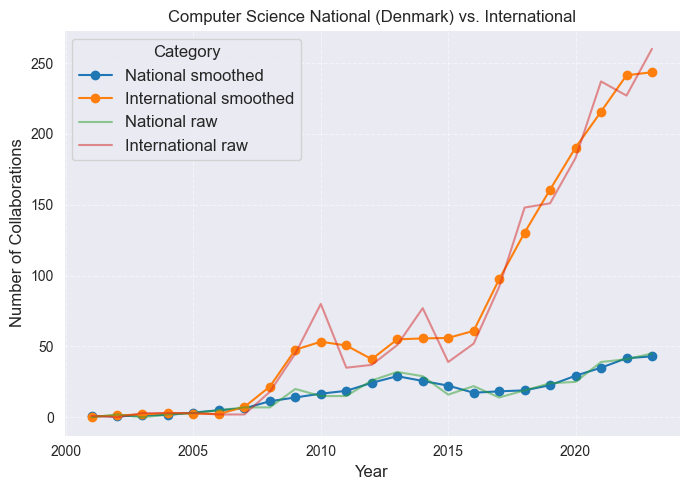

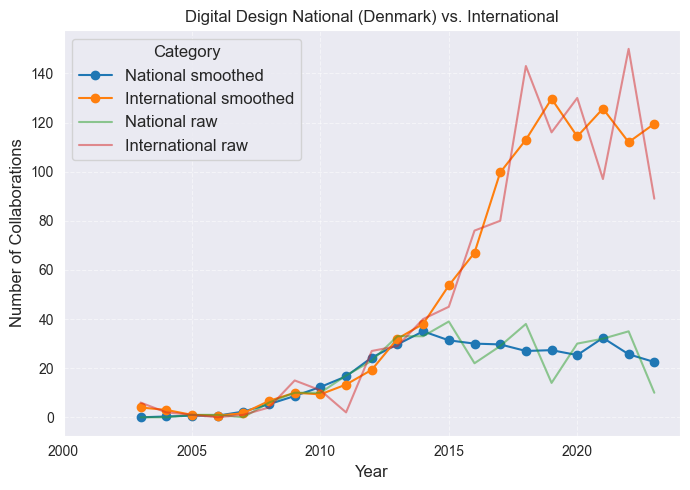

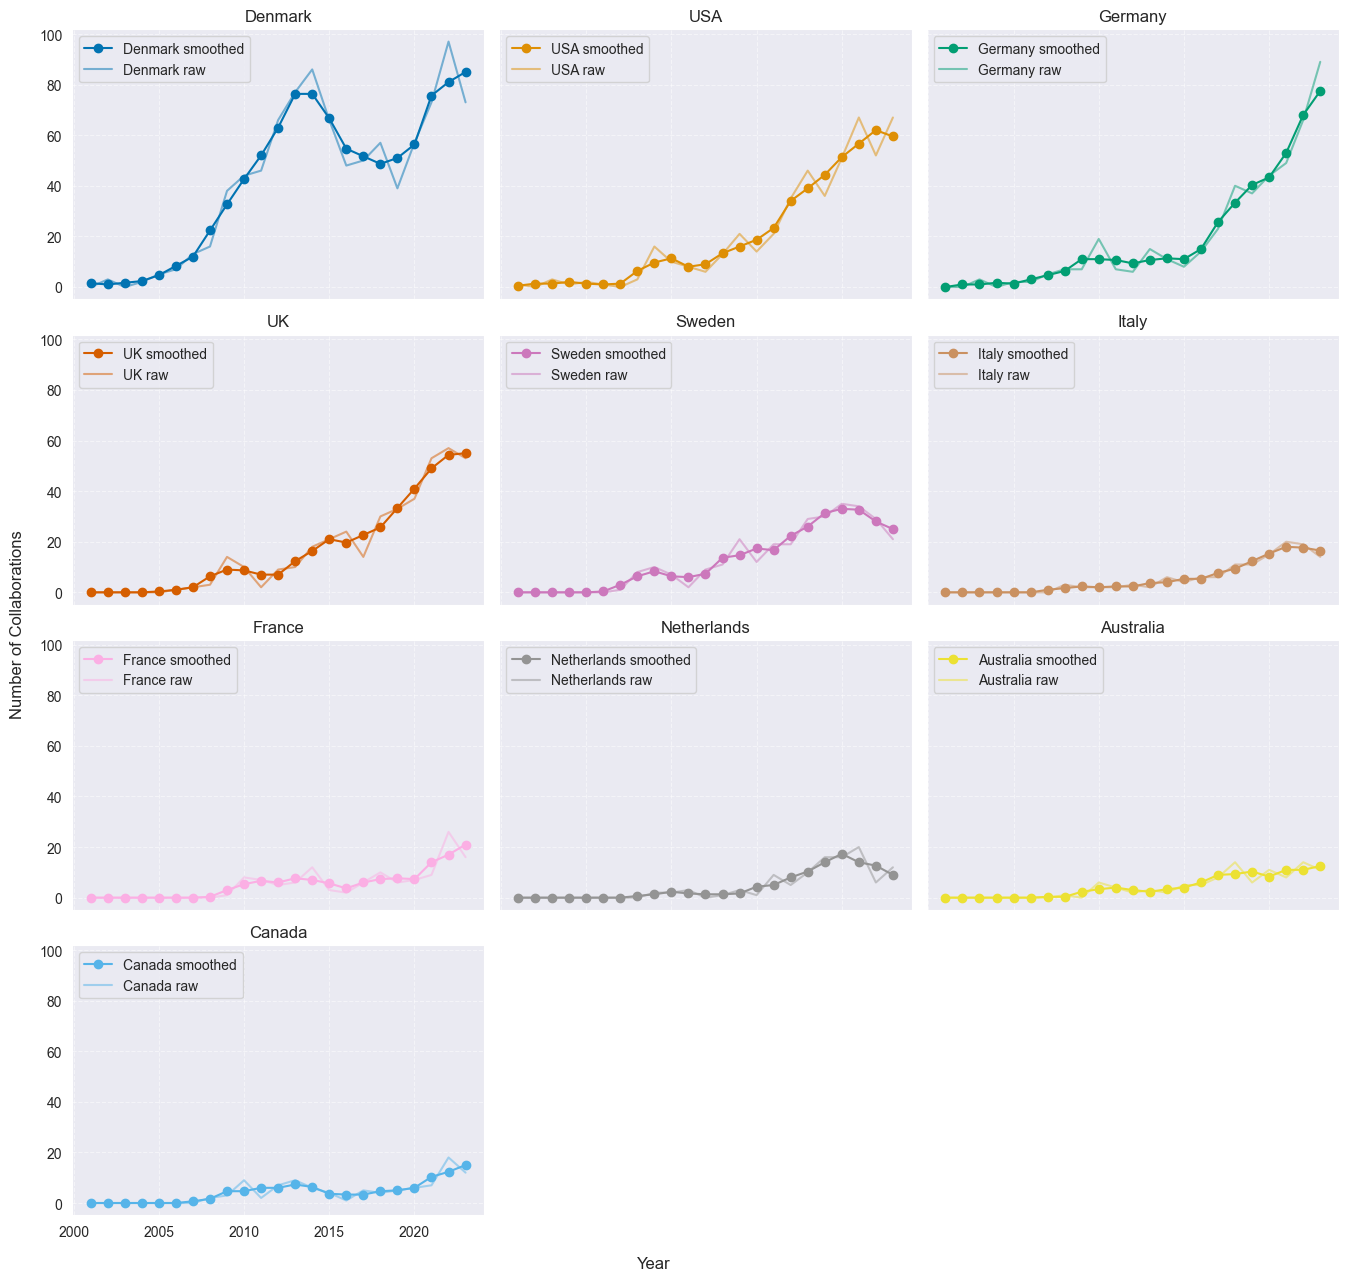

In [279]:
#Plot all Visualisations

department=None
international_cummulated=True
plot_collaborations(df, years, top_n=10, international_cummulated=international_cummulated, smoothing="centered", department = department)

for department in valid_departments:
    plot_collaborations(df, years, top_n=10, international_cummulated=international_cummulated, smoothing="centered", department = department)
international_cummulated=False
department=None
plot_collaborations(df, years, top_n=10, international_cummulated=international_cummulated, smoothing="centered", department = department)

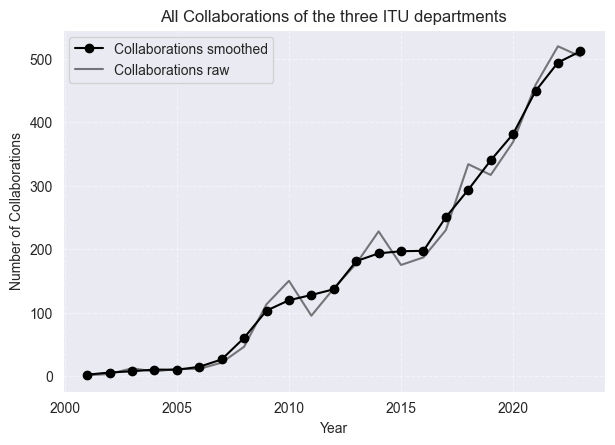

In [280]:
#plot trend of all collaborations
def plot_all_collaborations(df, window=3, smoothing="centered"):
    df_filtered = df[df['Year'].isin(years)]
    yearly_country_counts = df_filtered.groupby(['Year', 'Country']).size().reset_index(name='Collaborations')
    pivot_df = yearly_country_counts.pivot(index='Year', columns='Country', values='Collaborations').fillna(0)
    pivot_df['Aggregated'] = pivot_df.sum(axis=1)
    plot_df = pivot_df.rolling(window=window, min_periods=1, center=True).mean()
    plt.figure(figsize=(7, 4.7))
    plt.plot(pivot_df.index, plot_df['Aggregated'], marker="o", label="Collaborations smoothed", color='black')
    plt.plot(pivot_df.index, pivot_df['Aggregated'], label="Collaborations raw", alpha=0.5, color='black')
    plt.xlabel("Year")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylabel("Number of Collaborations")
    plt.legend()
    plt.title("All Collaborations of the three ITU departments")

    # Display the plot
    plt.show()

plot_all_collaborations(df)

#ax.plot(top_df_alpha.index, top_df_alpha[country], label=f"{country} raw", alpha=0.5, color=color)